# Modelling and Testing
### This notebook is used for modeling and testing code

In [40]:
import os
import pandas as pd
import numpy as np
import nltk
import praw
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud, STOPWORDS 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import datetime as dt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
%matplotlib inline

In [41]:
flairs = ["AskIndia", "Non-Political", "[R]eddiquette", 
          "Scheduled", "Photography", "Science/Technology", "Politics",
          "Business/Finance", "Policy/Economy", "Sports", "Food", "AMA", "Coronavirus",
         "CAA-NRC-NPR" ]

In [42]:
import warnings
warnings.filterwarnings("ignore")
## Remember to add documentation before sending
from tqdm import tqdm

In [43]:
df=pd.read_csv("reddit-india-data.csv")
df.columns

Index(['flair', 'title', 'score', 'id', 'url', 'comms_num', 'created', 'body',
       'author', 'comments'],
      dtype='object')

the snippet below is the set of stopwords

In [44]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", "nan","https", "www", "com" ])

##### The snippet below takes any text as input and replaces shortcuts, so that while removing special characters everything 

In [45]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

1. The snippet below removes all special characters
2. removes all html tags
3. removes links

In [46]:
df["Text"] = df["title"].map(str) + df["body"].map(str) + df["comments"].map(str) 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████████████████████████████████████████████| 2898/2898 [00:08<00:00, 347.44it/s]


## Bag of Words Vectorizations

1. Splits data into train and test
2. The snippet below vectorizes the text data using BoW featurization technique


In [47]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
y=df['flair'][:]
# y = preprocessing.label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
X=preprocessed_reviews[:]

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
bow = CountVectorizer()
X_train_bow=bow.fit_transform(X_train)
X_test_bow=bow.transform(X_test)
print(X_train_bow.shape, y_train.shape)

(2028, 44194) (2028,)


Cell Below removes warnings
Code abstractly taken from Stackoverflow to remove warnings

In [48]:
##https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings
import warnings
warnings.filterwarnings("ignore")

### Naive Bayes

accuracy 0.44482758620689655
classification report                     precision    recall  f1-score   support

          AskIndia       0.33      0.79      0.46        72
     Non-Political       0.14      0.48      0.21        63
     [R]eddiquette       0.53      0.63      0.58        76
         Scheduled       0.86      0.51      0.64        35
       Photography       0.86      0.10      0.18        61
Science/Technology       0.94      0.23      0.37        74
          Politics       1.00      0.09      0.17        77
  Business/Finance       0.88      0.60      0.71        62
    Policy/Economy       0.48      0.64      0.55        67
            Sports       0.40      0.45      0.42        62
              Food       0.88      0.20      0.33        74
               AMA       0.59      0.49      0.53        72
       Coronavirus       0.85      0.68      0.75        68
       CAA-NRC-NPR       0.00      0.00      0.00         7

       avg / total       0.67      0.44      0.

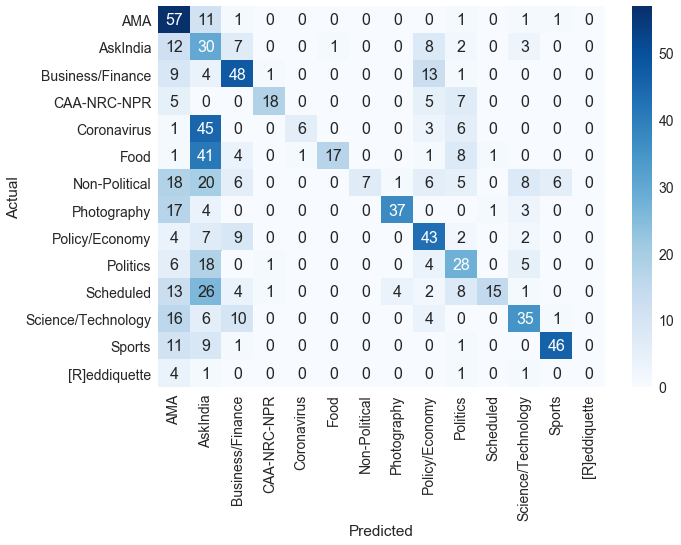

In [49]:
from sklearn.naive_bayes import MultinomialNB
clf=MultinomialNB()

clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()


### Logistic Regression

In [50]:
from sklearn.linear_model import SGDClassifier
clf=SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)

clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=flairs))

accuracy 0.41839080459770117
                    precision    recall  f1-score   support

          AskIndia       0.62      0.51      0.56        72
     Non-Political       0.13      0.87      0.22        63
     [R]eddiquette       0.54      0.64      0.59        76
         Scheduled       0.82      0.66      0.73        35
       Photography       0.73      0.31      0.44        61
Science/Technology       0.70      0.26      0.38        74
          Politics       0.96      0.31      0.47        77
  Business/Finance       0.73      0.61      0.67        62
    Policy/Economy       0.81      0.25      0.39        67
            Sports       0.53      0.29      0.38        62
              Food       0.87      0.18      0.29        74
               AMA       0.87      0.18      0.30        72
       Coronavirus       0.86      0.56      0.68        68
       CAA-NRC-NPR       0.20      0.14      0.17         7

       avg / total       0.70      0.42      0.46       870



### Support vector Machine(SVM) with L2 regularizer

accuracy 0.4126436781609195
classification report                     precision    recall  f1-score   support

          AskIndia       0.57      0.54      0.55        72
     Non-Political       0.13      0.83      0.22        63
     [R]eddiquette       0.62      0.62      0.62        76
         Scheduled       0.78      0.60      0.68        35
       Photography       0.68      0.41      0.51        61
Science/Technology       0.78      0.34      0.47        74
          Politics       0.96      0.29      0.44        77
  Business/Finance       0.82      0.44      0.57        62
    Policy/Economy       0.85      0.25      0.39        67
            Sports       0.49      0.31      0.38        62
              Food       0.81      0.18      0.29        74
               AMA       0.88      0.19      0.32        72
       Coronavirus       0.79      0.56      0.66        68
       CAA-NRC-NPR       0.00      0.00      0.00         7

       avg / total       0.70      0.41      0.4

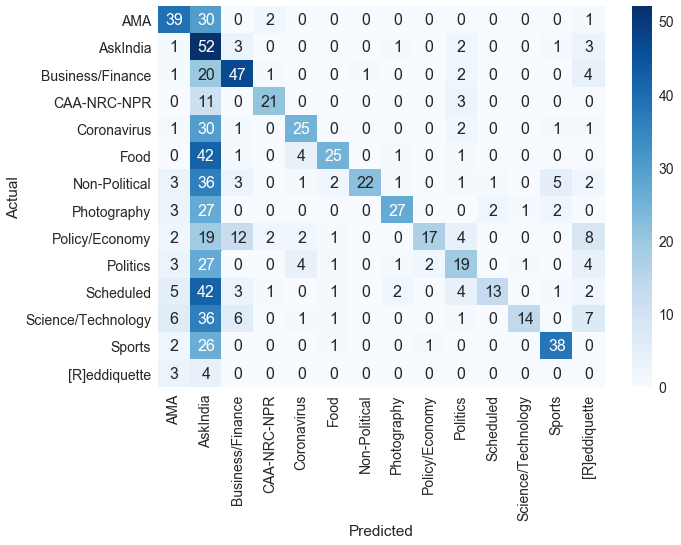

In [51]:
clf=SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)

clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

### Decision Trees

accuracy 0.764367816091954
classification report                     precision    recall  f1-score   support

          AskIndia       0.82      0.92      0.87        72
     Non-Political       0.82      0.84      0.83        63
     [R]eddiquette       0.64      0.58      0.61        76
         Scheduled       0.81      0.97      0.88        35
       Photography       0.81      0.85      0.83        61
Science/Technology       0.82      0.81      0.82        74
          Politics       0.77      0.83      0.80        77
  Business/Finance       0.92      0.87      0.89        62
    Policy/Economy       0.54      0.54      0.54        67
            Sports       0.56      0.58      0.57        62
              Food       0.76      0.76      0.76        74
               AMA       0.82      0.71      0.76        72
       Coronavirus       0.86      0.84      0.85        68
       CAA-NRC-NPR       1.00      0.29      0.44         7

       avg / total       0.77      0.76      0.76

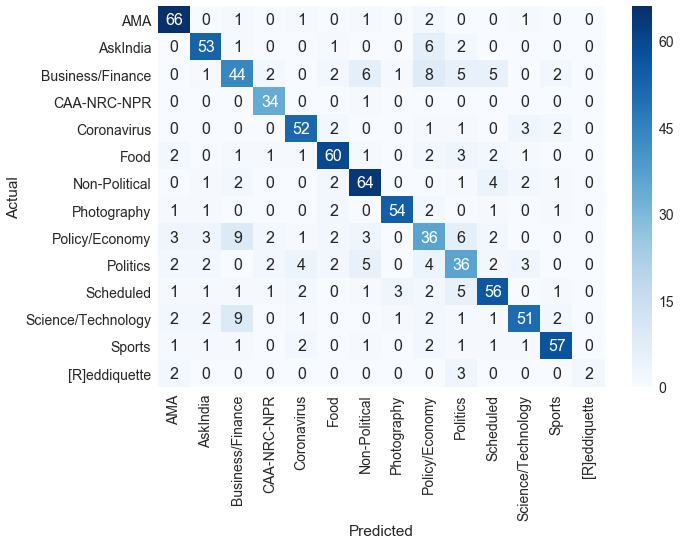

In [52]:
clf=tree.DecisionTreeClassifier()

clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

### Random Forests

accuracy 0.7965517241379311
classification report                     precision    recall  f1-score   support

          AskIndia       0.72      0.94      0.81        72
     Non-Political       0.84      0.75      0.79        63
     [R]eddiquette       0.80      0.78      0.79        76
         Scheduled       0.86      0.91      0.89        35
       Photography       0.67      0.93      0.78        61
Science/Technology       0.88      0.76      0.81        74
          Politics       0.89      0.86      0.87        77
  Business/Finance       0.85      0.85      0.85        62
    Policy/Economy       0.62      0.67      0.64        67
            Sports       0.59      0.63      0.61        62
              Food       0.96      0.66      0.78        74
               AMA       0.85      0.81      0.83        72
       Coronavirus       0.98      0.88      0.93        68
       CAA-NRC-NPR       1.00      0.57      0.73         7

       avg / total       0.81      0.80      0.8

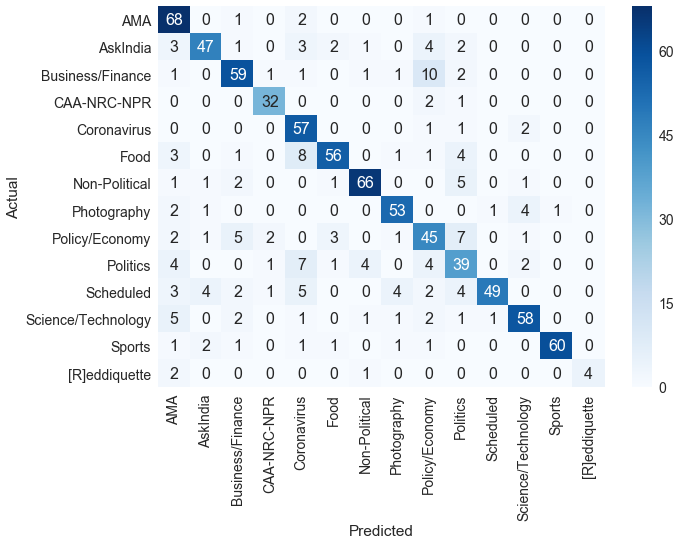

In [53]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators = 1000, random_state = 42)

clf.fit(X_train_bow, y_train)
y_pred = clf.predict(X_test_bow)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

## Using TFIDF Vectorizations

In [54]:
y=df['flair'][:]
# y = preprocessing.label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
X=preprocessed_reviews[:]

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=42)
tfidf = TfidfVectorizer()
X_train_tfidf=tfidf.fit_transform(X_train)
X_test_tfidf=tfidf.transform(X_test)
print(X_train_tfidf.shape, y_train.shape)

(2028, 44194) (2028,)


In [55]:
joblib.dump(tfidf, 'count_vect.pkl')

['count_vect.pkl']

### Naive Bayes

accuracy 0.5517241379310345
classification report                     precision    recall  f1-score   support

          AskIndia       0.75      0.57      0.65        72
     Non-Political       0.27      0.62      0.38        63
     [R]eddiquette       0.47      0.75      0.58        76
         Scheduled       1.00      0.29      0.44        35
       Photography       0.85      0.57      0.69        61
Science/Technology       0.83      0.70      0.76        74
          Politics       1.00      0.12      0.21        77
  Business/Finance       0.88      0.74      0.81        62
    Policy/Economy       0.52      0.63      0.57        67
            Sports       0.26      0.79      0.40        62
              Food       0.92      0.30      0.45        74
               AMA       0.84      0.44      0.58        72
       Coronavirus       0.94      0.68      0.79        68
       CAA-NRC-NPR       0.00      0.00      0.00         7

       avg / total       0.72      0.55      0.5

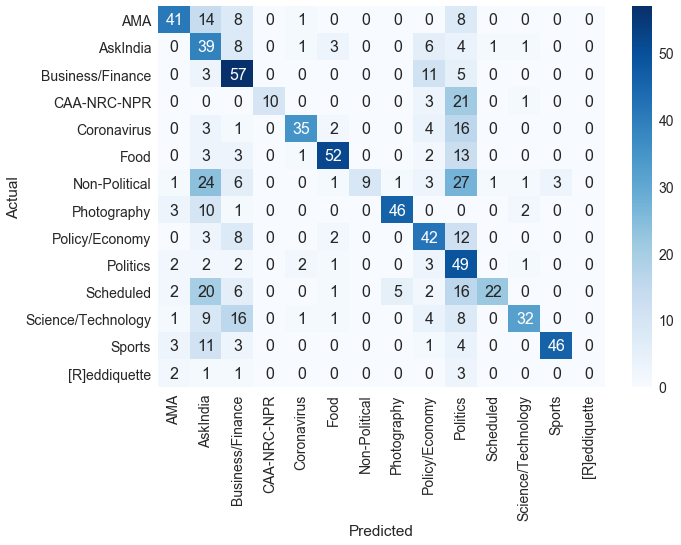

In [56]:
clf=MultinomialNB()

clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

### Logistic Regression

accuracy 0.7298850574712644
classification report                     precision    recall  f1-score   support

          AskIndia       0.77      0.83      0.80        72
     Non-Political       0.48      0.68      0.57        63
     [R]eddiquette       0.78      0.68      0.73        76
         Scheduled       0.80      0.69      0.74        35
       Photography       0.75      0.89      0.81        61
Science/Technology       0.80      0.81      0.81        74
          Politics       0.88      0.60      0.71        77
  Business/Finance       0.92      0.87      0.89        62
    Policy/Economy       0.57      0.64      0.60        67
            Sports       0.45      0.68      0.54        62
              Food       0.89      0.57      0.69        74
               AMA       0.82      0.76      0.79        72
       Coronavirus       0.94      0.87      0.90        68
       CAA-NRC-NPR       1.00      0.14      0.25         7

       avg / total       0.76      0.73      0.7

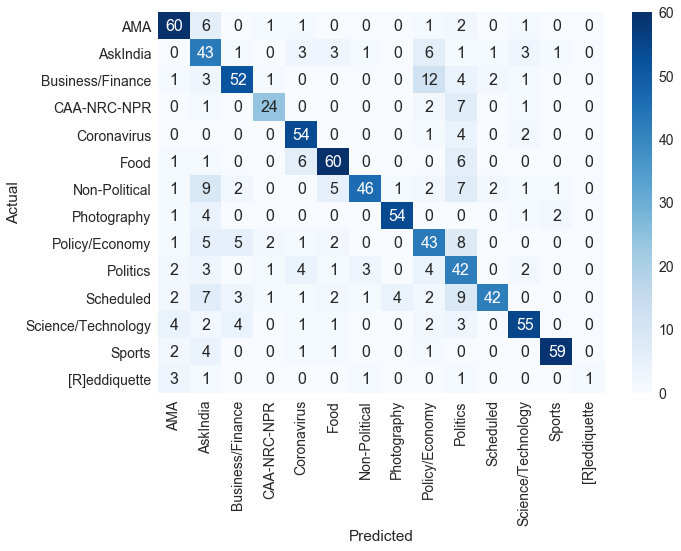

In [57]:
clf=SGDClassifier(loss='log', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)

clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

### SVM with L2 regularizer

accuracy 0.774712643678161
classification report                     precision    recall  f1-score   support

          AskIndia       0.77      0.89      0.83        72
     Non-Political       0.82      0.51      0.63        63
     [R]eddiquette       0.76      0.74      0.75        76
         Scheduled       0.78      0.89      0.83        35
       Photography       0.72      0.97      0.83        61
Science/Technology       0.78      0.84      0.81        74
          Politics       0.87      0.79      0.83        77
  Business/Finance       0.78      0.92      0.84        62
    Policy/Economy       0.64      0.70      0.67        67
            Sports       0.67      0.55      0.60        62
              Food       0.87      0.64      0.73        74
               AMA       0.71      0.81      0.75        72
       Coronavirus       0.94      0.91      0.93        68
       CAA-NRC-NPR       1.00      0.57      0.73         7

       avg / total       0.78      0.77      0.77

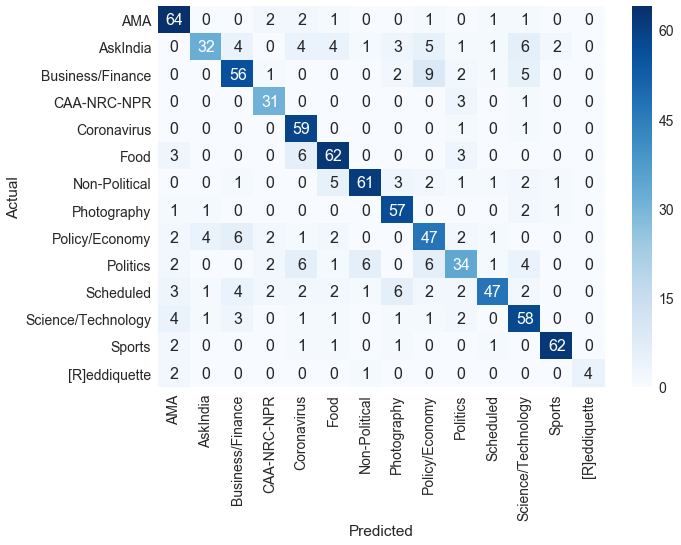

In [58]:
clf=SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

### Decision Trees

accuracy 0.7655172413793103
classification report                     precision    recall  f1-score   support

          AskIndia       0.76      0.85      0.80        72
     Non-Political       0.81      0.89      0.85        63
     [R]eddiquette       0.67      0.71      0.69        76
         Scheduled       0.84      0.91      0.88        35
       Photography       0.78      0.85      0.81        61
Science/Technology       0.81      0.76      0.78        74
          Politics       0.79      0.81      0.80        77
  Business/Finance       0.88      0.85      0.87        62
    Policy/Economy       0.60      0.55      0.57        67
            Sports       0.59      0.60      0.59        62
              Food       0.83      0.73      0.78        74
               AMA       0.83      0.74      0.78        72
       Coronavirus       0.80      0.84      0.82        68
       CAA-NRC-NPR       0.67      0.29      0.40         7

       avg / total       0.77      0.77      0.7

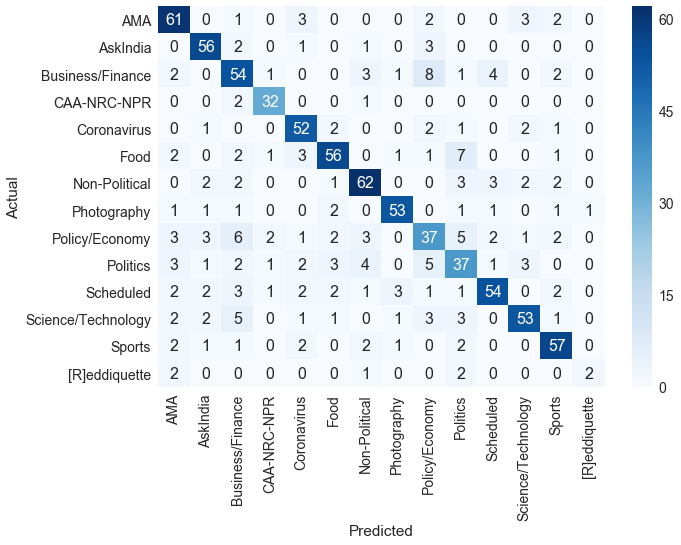

In [59]:
clf=tree.DecisionTreeClassifier()
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

### Random Forests 
Next 3 snippets has RF classifiers using different number of estimators

accuracy 0.7977011494252874
classification report                     precision    recall  f1-score   support

          AskIndia       0.76      0.94      0.84        72
     Non-Political       0.83      0.76      0.79        63
     [R]eddiquette       0.78      0.82      0.80        76
         Scheduled       0.84      0.89      0.86        35
       Photography       0.67      0.87      0.76        61
Science/Technology       0.87      0.78      0.82        74
          Politics       0.89      0.84      0.87        77
  Business/Finance       0.87      0.87      0.87        62
    Policy/Economy       0.67      0.66      0.66        67
            Sports       0.54      0.61      0.58        62
              Food       0.94      0.68      0.79        74
               AMA       0.83      0.82      0.83        72
       Coronavirus       0.98      0.88      0.93        68
       CAA-NRC-NPR       1.00      0.57      0.73         7

       avg / total       0.81      0.80      0.8

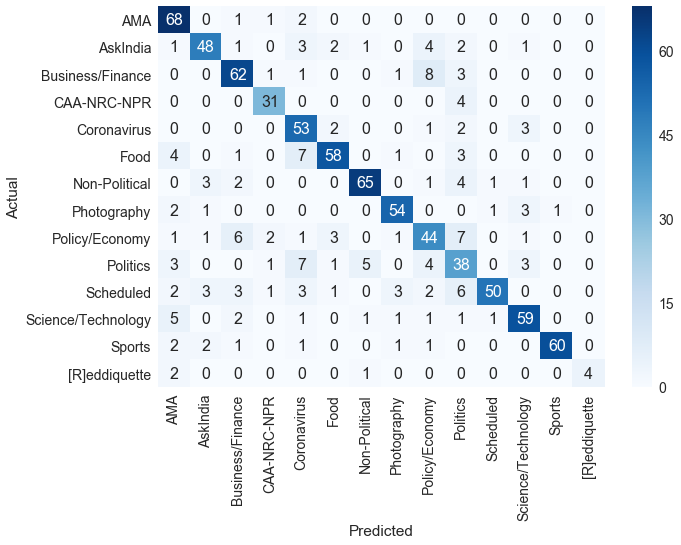

In [60]:
clf=RandomForestClassifier(n_estimators = 1000, random_state = 42)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

accuracy 0.7977011494252874
classification report                     precision    recall  f1-score   support

          AskIndia       0.73      0.94      0.82        72
     Non-Political       0.82      0.75      0.78        63
     [R]eddiquette       0.80      0.79      0.79        76
         Scheduled       0.82      0.91      0.86        35
       Photography       0.68      0.87      0.76        61
Science/Technology       0.85      0.78      0.82        74
          Politics       0.90      0.84      0.87        77
  Business/Finance       0.87      0.87      0.87        62
    Policy/Economy       0.68      0.67      0.68        67
            Sports       0.54      0.61      0.57        62
              Food       0.96      0.68      0.79        74
               AMA       0.83      0.83      0.83        72
       Coronavirus       0.98      0.88      0.93        68
       CAA-NRC-NPR       1.00      0.57      0.73         7

       avg / total       0.81      0.80      0.8

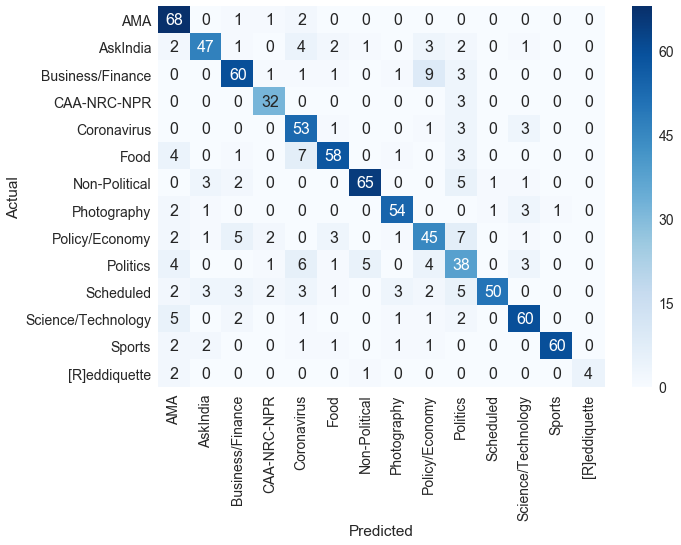

In [61]:
clf=RandomForestClassifier(n_estimators = 1500, random_state = 42)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

accuracy 0.7988505747126436
classification report                     precision    recall  f1-score   support

          AskIndia       0.76      0.94      0.84        72
     Non-Political       0.80      0.76      0.78        63
     [R]eddiquette       0.78      0.79      0.78        76
         Scheduled       0.82      0.91      0.86        35
       Photography       0.68      0.89      0.77        61
Science/Technology       0.84      0.78      0.81        74
          Politics       0.89      0.83      0.86        77
  Business/Finance       0.87      0.85      0.86        62
    Policy/Economy       0.67      0.66      0.66        67
            Sports       0.60      0.63      0.61        62
              Food       0.96      0.72      0.82        74
               AMA       0.83      0.82      0.83        72
       Coronavirus       0.95      0.87      0.91        68
       CAA-NRC-NPR       1.00      0.57      0.73         7

       avg / total       0.81      0.80      0.8

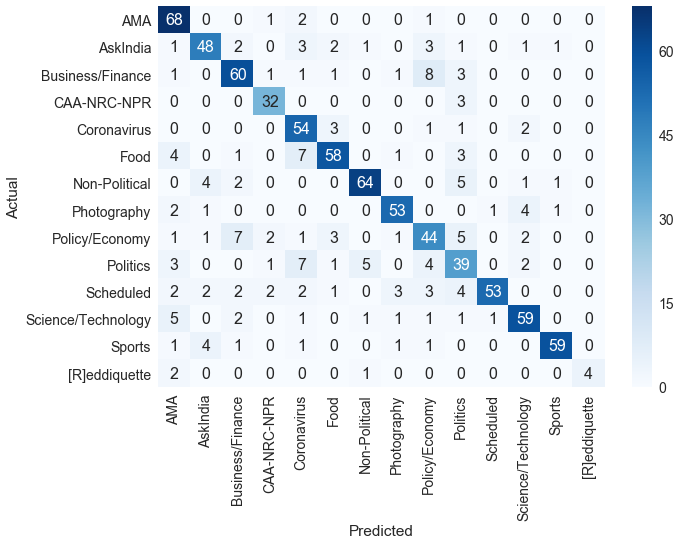

In [62]:
clf=RandomForestClassifier(n_estimators = 500, random_state = 42)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()

In [63]:
# joblib.dump(clf, 'model.pkl')

##### Well, till now we have been trying Random Forests which is an ensemble methood
##### Problem: The dumped pickle file has a size of 131 MB
##### It can't be pushed to github now. So, lets tune SVM as it also has an okayish performance

C for SVM is :  1e-06
Train accuracy :  0.9738658777120316
Val accuracy :  0.6873563218390805


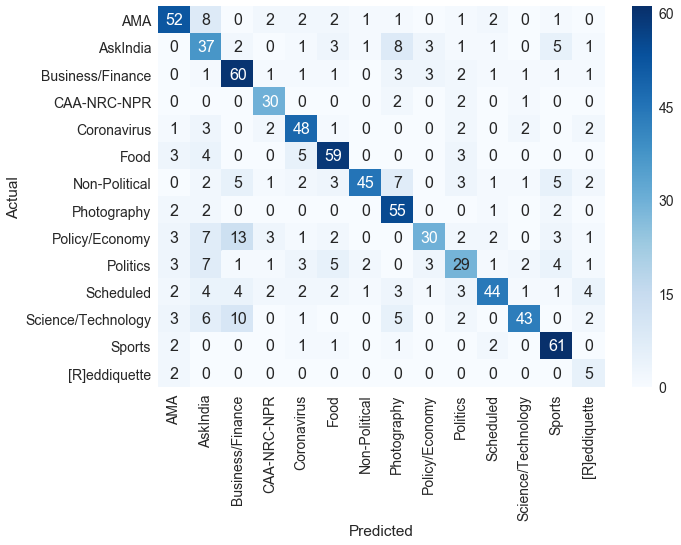

--------------------------------------------------------------------------------
C for SVM is :  1e-05
Train accuracy :  0.9733727810650887
Val accuracy :  0.7436781609195402


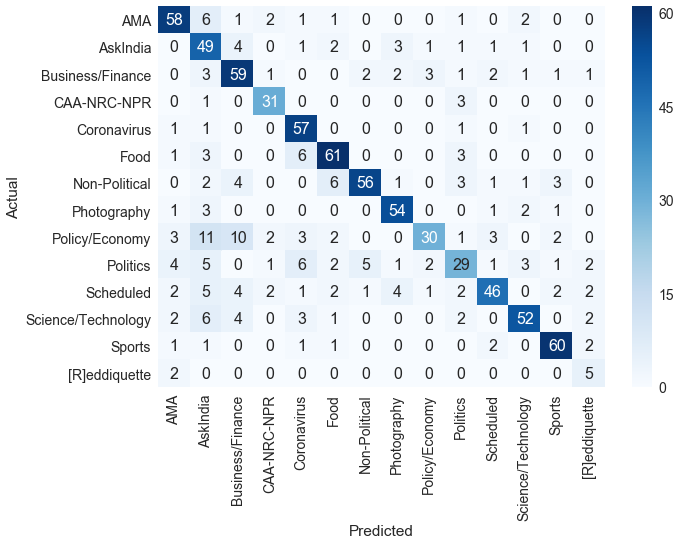

--------------------------------------------------------------------------------
C for SVM is :  0.0001
Train accuracy :  0.9575936883629191
Val accuracy :  0.7965517241379311


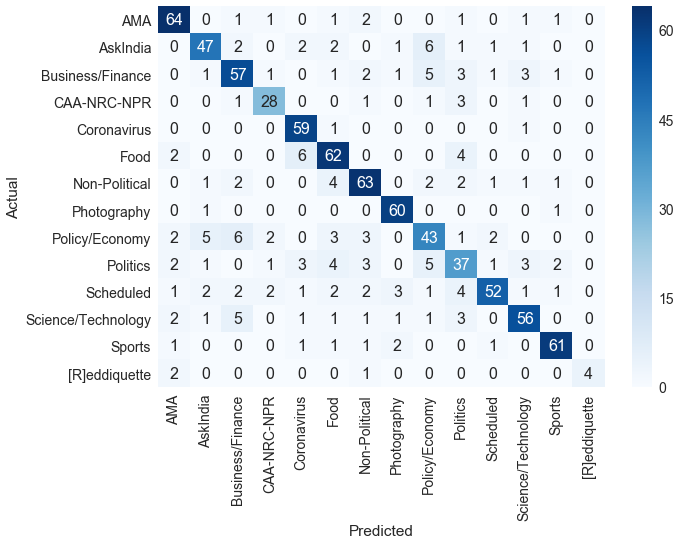

--------------------------------------------------------------------------------
C for SVM is :  0.001
Train accuracy :  0.7864891518737672
Val accuracy :  0.7850574712643679


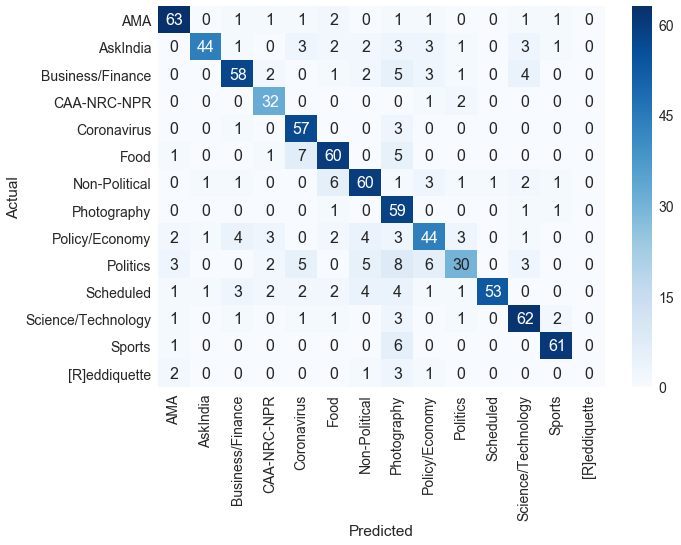

--------------------------------------------------------------------------------
C for SVM is :  0.01
Train accuracy :  0.15285996055226825
Val accuracy :  0.1471264367816092


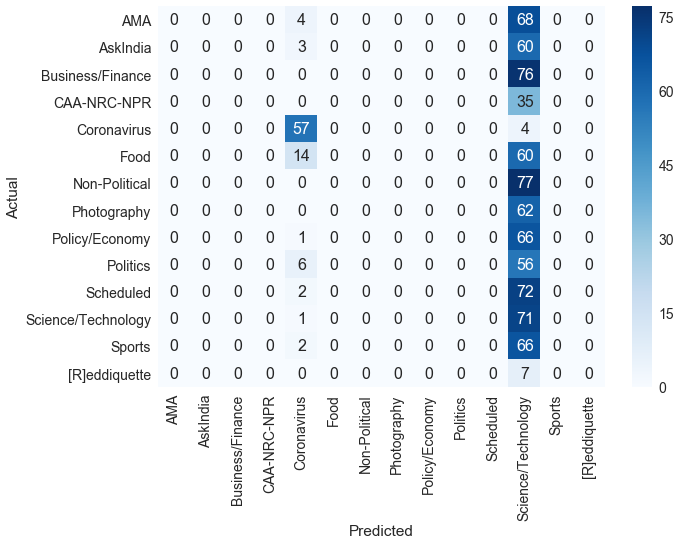

--------------------------------------------------------------------------------
C for SVM is :  0.1
Train accuracy :  0.07741617357001973
Val accuracy :  0.08735632183908046


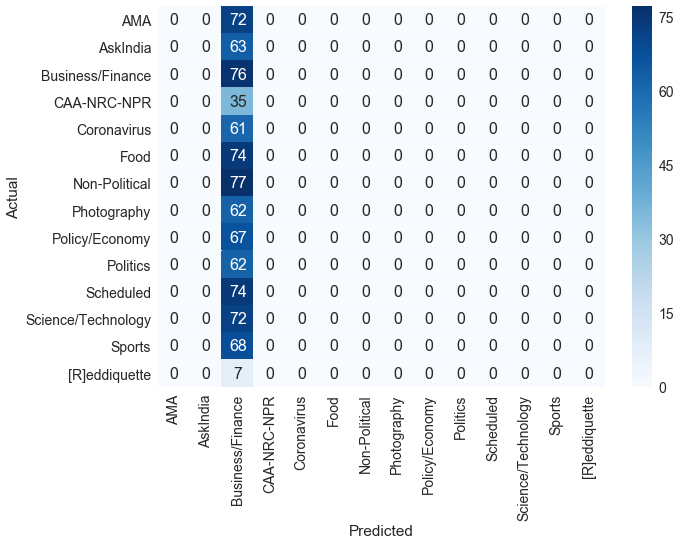

--------------------------------------------------------------------------------
C for SVM is :  1
Train accuracy :  0.07889546351084813
Val accuracy :  0.08505747126436781


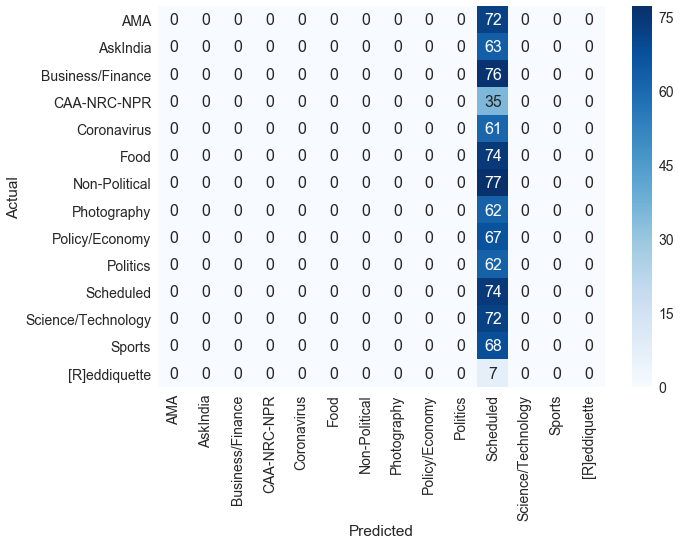

--------------------------------------------------------------------------------
C for SVM is :  10
Train accuracy :  0.07889546351084813
Val accuracy :  0.08505747126436781


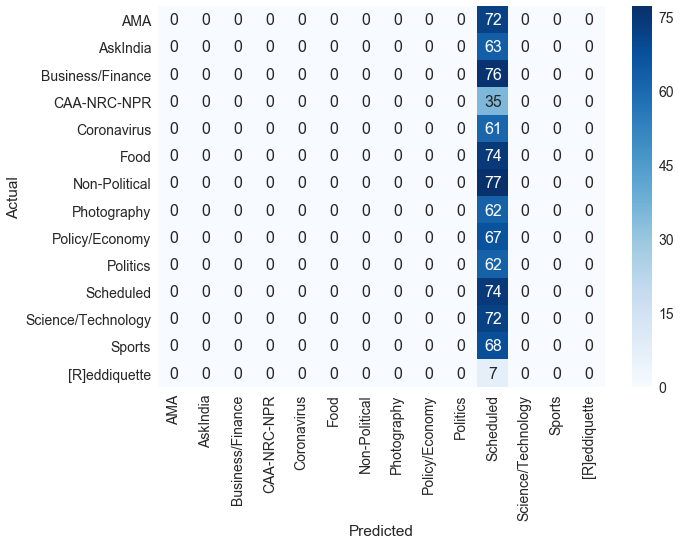

--------------------------------------------------------------------------------
C for SVM is :  100
Train accuracy :  0.07889546351084813
Val accuracy :  0.08505747126436781


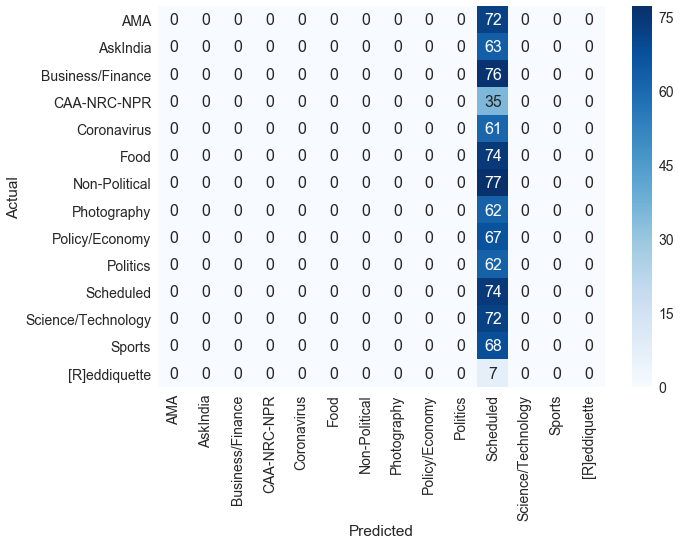

--------------------------------------------------------------------------------
C for SVM is :  1000
Train accuracy :  0.07889546351084813
Val accuracy :  0.08505747126436781


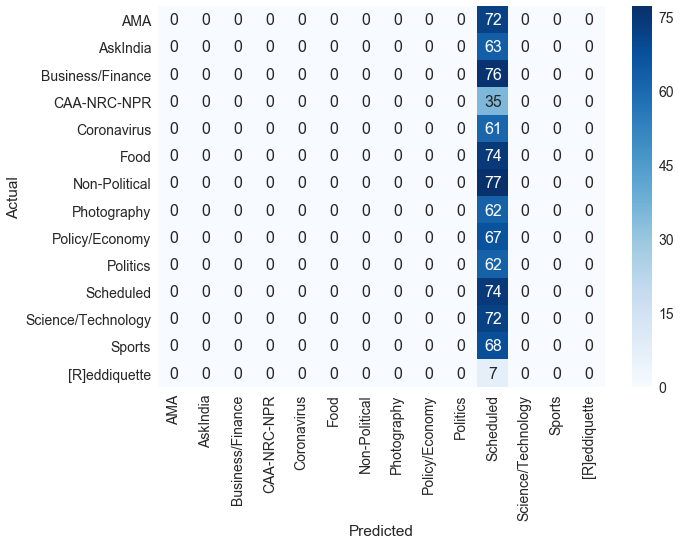

--------------------------------------------------------------------------------


In [64]:
alphas=[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_acc=[]
val_acc=[]
for i in alphas:
    print("C for SVM is : ", i)
    clf=SGDClassifier(loss='hinge', penalty='l1',alpha=i, random_state=42, max_iter=5, tol=None)
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    pred=clf.predict(X_train_tfidf)
    train_accuracy=accuracy_score(pred, y_train)
    val_accuracy=accuracy_score(y_pred, y_test)
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)
    print('Train accuracy : ', train_accuracy )
    print('Val accuracy : ', val_accuracy )
#     print("classification report",classification_report(y_test, y_pred,target_names=flairs))
    data = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
    plt.show()
    print("-"*80)

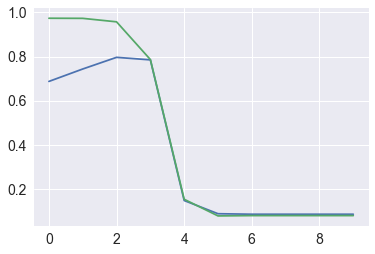

In [65]:
# print(val_acc)
# print(train_acc)
plt.plot(val_acc, label='Validation loss')
plt.plot(train_acc, label='train loss')

##### Repeating the same process using l2 regularizer

C for SVM is :  1e-06
Train accuracy :  0.9733727810650887
Val accuracy :  0.7114942528735633


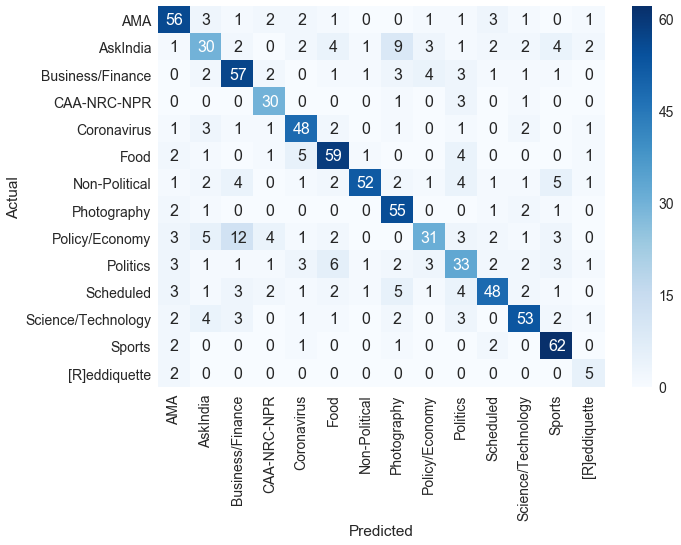

--------------------------------------------------------------------------------
C for SVM is :  1e-05
Train accuracy :  0.9723865877712031
Val accuracy :  0.7195402298850575


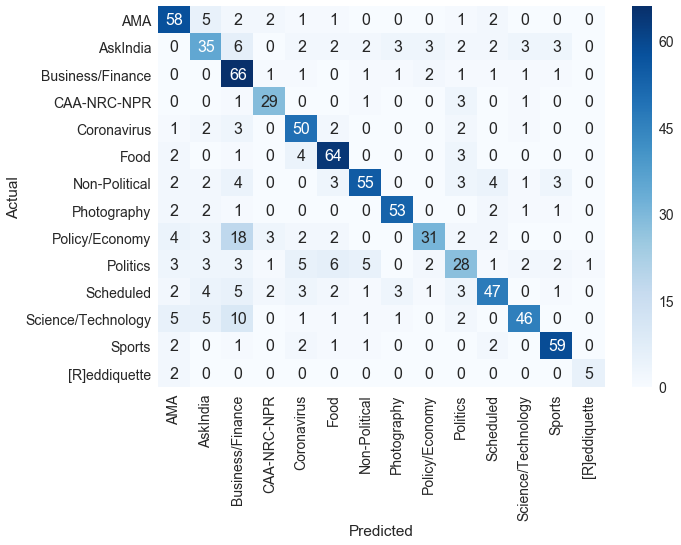

--------------------------------------------------------------------------------
C for SVM is :  0.0001
Train accuracy :  0.9738658777120316
Val accuracy :  0.7632183908045977


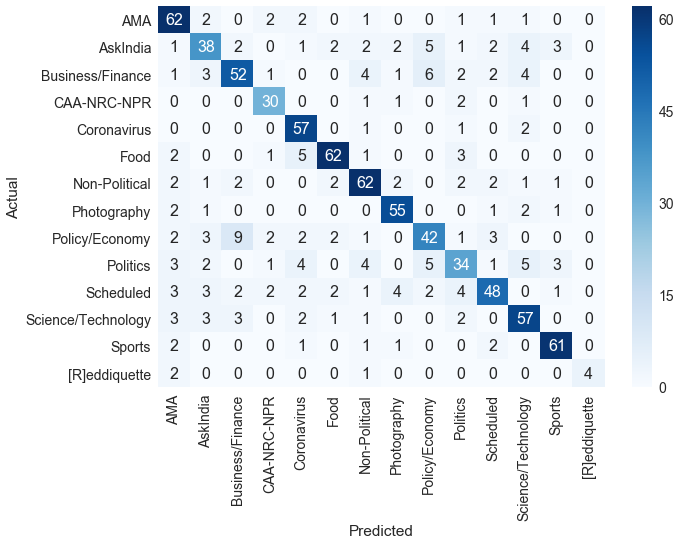

--------------------------------------------------------------------------------
C for SVM is :  0.001
Train accuracy :  0.9551282051282052
Val accuracy :  0.774712643678161


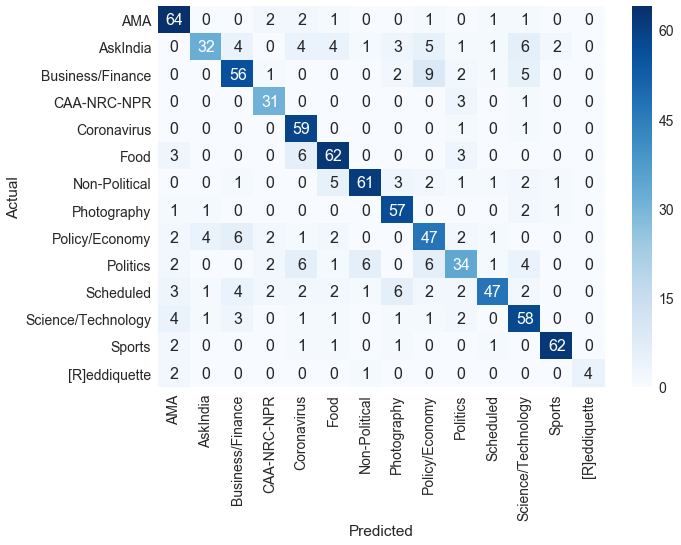

--------------------------------------------------------------------------------
C for SVM is :  0.01
Train accuracy :  0.9506903353057199
Val accuracy :  0.764367816091954


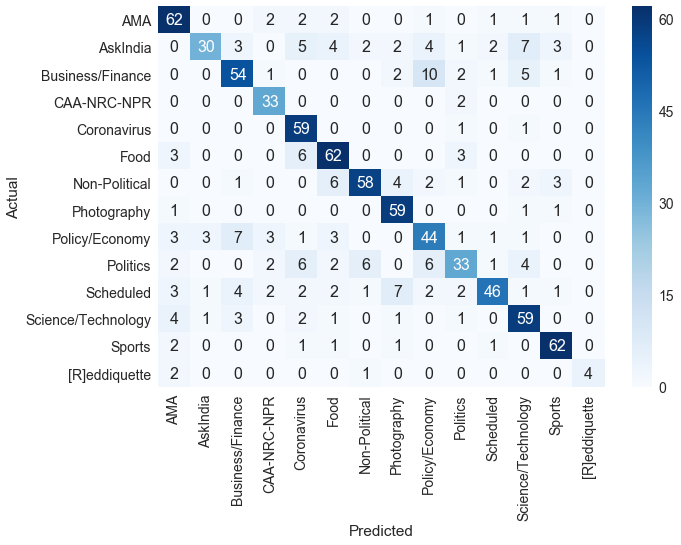

--------------------------------------------------------------------------------
C for SVM is :  0.1
Train accuracy :  0.5838264299802761
Val accuracy :  0.4666666666666667


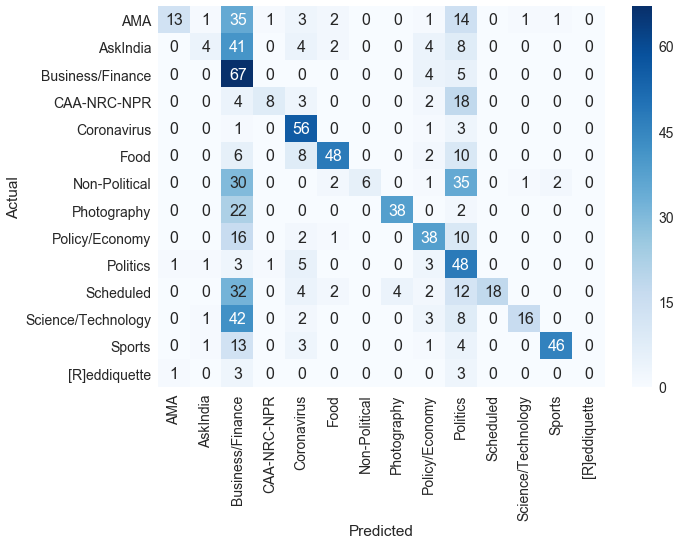

--------------------------------------------------------------------------------
C for SVM is :  1
Train accuracy :  0.11637080867850098
Val accuracy :  0.10919540229885058


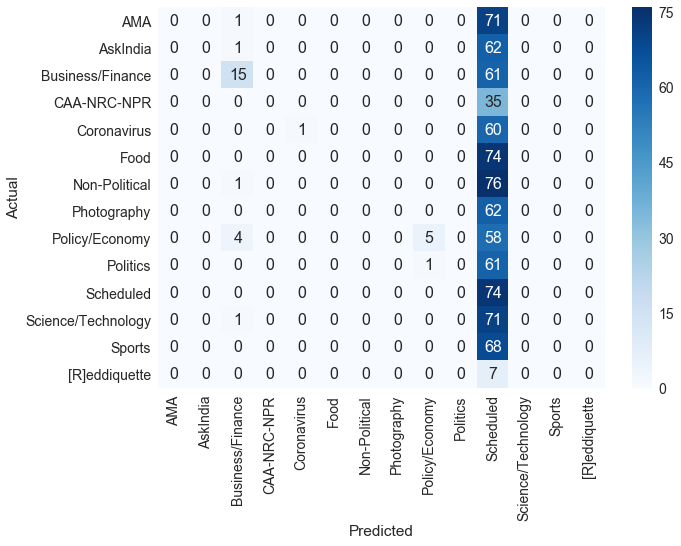

--------------------------------------------------------------------------------
C for SVM is :  10
Train accuracy :  0.07889546351084813
Val accuracy :  0.08505747126436781


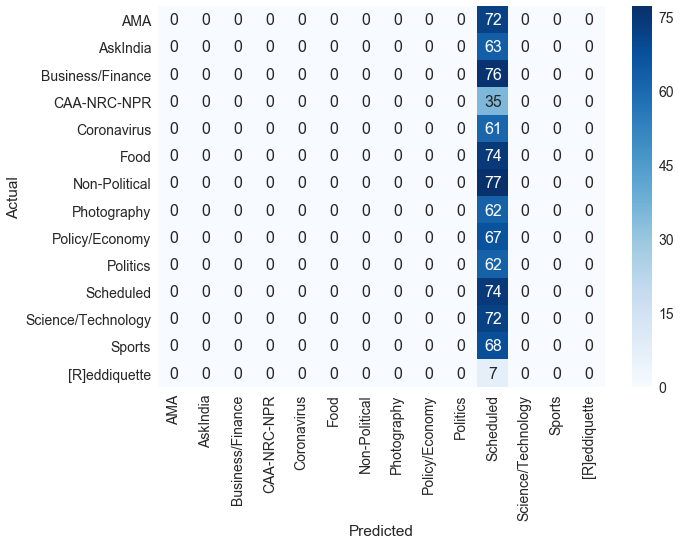

--------------------------------------------------------------------------------
C for SVM is :  100
Train accuracy :  0.07889546351084813
Val accuracy :  0.08505747126436781


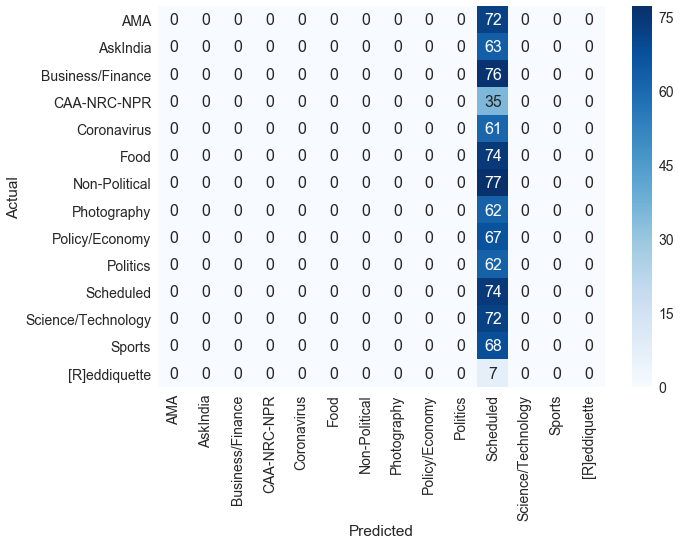

--------------------------------------------------------------------------------
C for SVM is :  1000
Train accuracy :  0.07889546351084813
Val accuracy :  0.08505747126436781


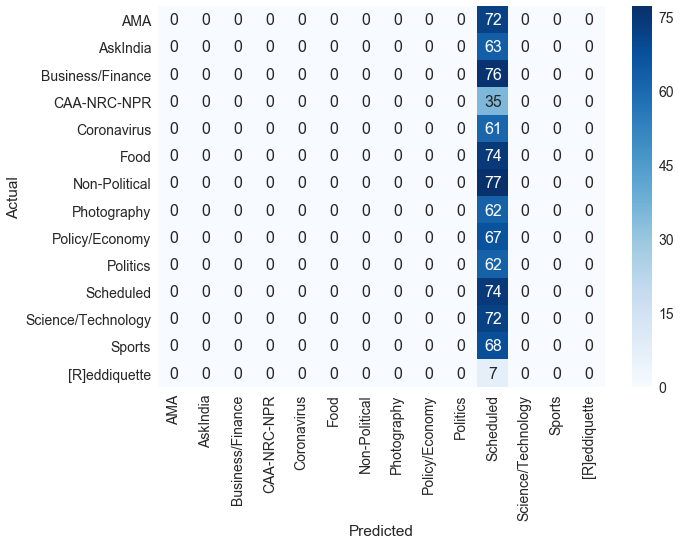

--------------------------------------------------------------------------------


In [66]:
alphas=[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_acc=[]
val_acc=[]
for i in alphas:
    print("C for SVM is : ", i)
    clf=SGDClassifier(loss='hinge', penalty='l2',alpha=i, random_state=42, max_iter=5, tol=None)
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    pred=clf.predict(X_train_tfidf)
    train_accuracy=accuracy_score(pred, y_train)
    val_accuracy=accuracy_score(y_pred, y_test)
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)
    print('Train accuracy : ', train_accuracy )
    print('Val accuracy : ', val_accuracy )
#     print("classification report",classification_report(y_test, y_pred,target_names=flairs))
    data = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
    plt.show()
    print("-"*80)

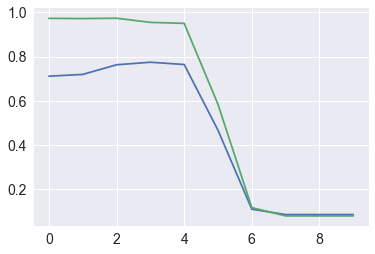

In [67]:
# print(val_acc)
# print(train_acc)
plt.plot(val_acc, label='Validation loss')
plt.plot(train_acc, label='train loss')

## Modelling Conclusions
1. L1 regularizer works better than L2 regularizer
2. C: 0.001 does not overfit with model

Train accuracy :  0.7864891518737672
Val accuracy :  0.7850574712643679


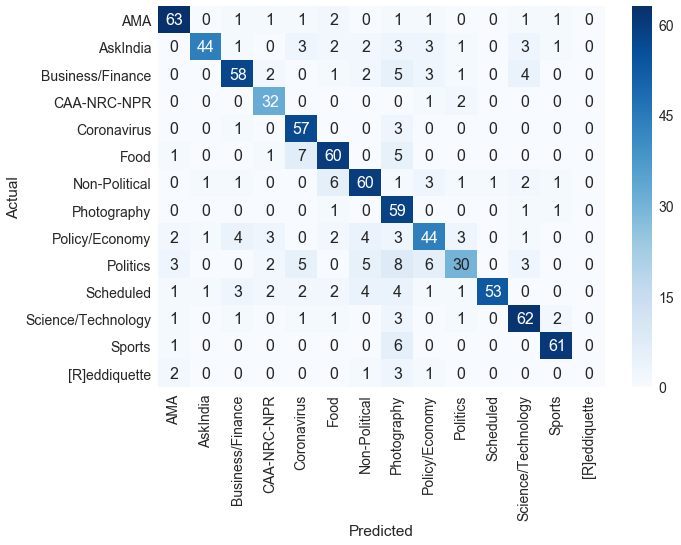

In [84]:
clf=SGDClassifier(loss='hinge', penalty='l1',alpha=0.001, random_state=42, max_iter=5, tol=None)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)
pred=clf.predict(X_train_tfidf)
train_accuracy=accuracy_score(pred, y_train)
val_accuracy=accuracy_score(y_pred, y_test)
print('Train accuracy : ', train_accuracy )
print('Val accuracy : ', val_accuracy )
# print("classification report",classification_report(y_test, y_pred,target_names=flairs))
data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(flairs), index = np.unique(flairs))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.savefig('confusion.png', dpi=400)
plt.show()

##### The snippet below dumps the above model into .pkl file which would be used for model deployment

In [69]:
# joblib.dump(clf, 'model.pkl')
# after dumping it once, it is commented to check on other cases

['model.pkl']

## Reporting Model Performances

##### The snippet below uses PrettyTable Library and produces tables

In [70]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer","Classifier", "Accuracy(%)"]

x.add_row(["Bag of Words" ,"Naive Bayes" ,44.4])
x.add_row(["Bag of Words" ,"Logistic Regression" ,41.8])
x.add_row(["Bag of Words" ,"SVM- L2 regularizer" ,41.2])
x.add_row(["Bag of Words" ,"Decision Trees" ,77.3])
x.add_row(["Bag of Words" ,"Random Forests" ,79.6])

x.add_row(["TFIDF" ,"Naive Bayes" ,55.17])
x.add_row(["TFIDF" ,"Logistic Regression" ,72.9])
x.add_row(["TFIDF" ,"SVM- L1 regularizer" ,78.5])
x.add_row(["TFIDF" ,"SVM L2 regularizer" ,77.4])
x.add_row(["TFIDF" ,"Decision Trees" ,76.4])
x.add_row(["TFIDF" ,"Random Forests" ,79.8])

print(x)

+--------------+---------------------+-------------+
|  Vectorizer  |      Classifier     | Accuracy(%) |
+--------------+---------------------+-------------+
| Bag of Words |     Naive Bayes     |     44.4    |
| Bag of Words | Logistic Regression |     41.8    |
| Bag of Words | SVM- L2 regularizer |     41.2    |
| Bag of Words |    Decision Trees   |     77.3    |
| Bag of Words |    Random Forests   |     79.6    |
|    TFIDF     |     Naive Bayes     |    55.17    |
|    TFIDF     | Logistic Regression |     72.9    |
|    TFIDF     | SVM- L1 regularizer |     78.5    |
|    TFIDF     |  SVM L2 regularizer |     77.4    |
|    TFIDF     |    Decision Trees   |     76.4    |
|    TFIDF     |    Random Forests   |     79.8    |
+--------------+---------------------+-------------+


### Why no deep learning model or any advanced embeddings?

1. Most embeddings have a weight more than 100 MB which can't be uploaded to Github
2. So, they need to deployed using AWS/GCP/Azure but not Heroku
3. Model performs well for Normal cases

# Testing Phase

### Now let's test on data from reddit
1. The data was scrapped on 18th feb
2. So, I am using fresh links from Reddit India now
3. For one example below, I am taking URL of Palghar Lynching happened yesterday
4. Link: https://www.reddit.com/r/india/comments/g4oun2/brutal_palghar_lynching_during_corona_lockdown/

##### The Snippet below takes URL from reddit  as input
##### and returns  title, body and top comments combined
The above two line is just to setup reddit api for scrapping

In [85]:
reddit = praw.Reddit(client_id='xqxZ6WzL6TC_PA', client_secret='DGlby5_lzNhqc6BkXOxfQgdxa3Y',
                     user_agent='Flair_Detector', username='Aman_Sawarn', password='izgNzhU87c$SmhT')

def detect_flair(url):
    submission = reddit.submission(url=url)
    
    data = {}
    data['title'] = submission.title
    data['url'] = submission.url
    submission.comments.replace_more(limit=None)
    comment = ''
    comment=comment+' '+submission.selftext
    for top_level_comment in submission.comments:
        comment = comment + ' ' + top_level_comment.body
    
    data["comment"] = comment
    data['title'] = decontracted(data['title'])
    data['comment'] = decontracted(data['comment'])
    data['combine'] = data['title'] + data['comment'] + data['url']
    
    return data['combine']

In [86]:
url='https://www.reddit.com/r/india/comments/g4oun2/brutal_palghar_lynching_during_corona_lockdown/'
detect_flair(url)

'Brutal Palghar lynching during Corona lockdown! @sifydotcom cartoon.  How come the police beat people up for going out to buy groceries, but when it actually comes to doing their job, they just stand, doing nothing? This captures the horrifying incident in the most apt way. Police letting it be, the WhatsApp rumours and fake news during the time of corona leading to deaths of 3 people. What the heck!? One of the three men was 70 years old. I cannnot even imagine what kind of a monster you would have to be to assault an aged person, who just wanted to attend a funeral. This is pretty much the last straw. I have **absolutely zero**  hopes for this country and anyone who tries to convince me otherwise is wasting their time, either trying to justify a failed democratic project or by having an over-optimistic outlook. Justice for the sadhus! Ok, why the hell Police brought those Sadhus there and the mob there beat them to death? Sorry, I am out of loop.\n\nEdit: Curiosity or should I say A

#### Prediction Stage
1. The cell below takes the combined text as input
2. i.e it takes the output of detect flair function as input to detect its flair
3. The Snippet below loads the model weights and count vectorizer
4. The text is cleaned using the decontracted function
5. After text is cleaned, it is transformed Using the TFIDF vectorizer
6. Transformed vector is given to model and Flair is predicted

In [92]:
def predict(string):
    clf = joblib.load('model.pkl')
    count_vect = joblib.load('count_vect.pkl')
    review_text = decontracted(string)
#     print(review_text)
    test_vect = count_vect.transform(([review_text]))
    pred = clf.predict(test_vect)

    return pred

### Model Success
1. Model performs well when it doesn't have images
2. Model Performs well when the results are not confusing
3. It is easier for model to detect right flairs in case of lesser confusion
4. Example: https://www.reddit.com/r/india/comments/g4p1tr/1000_foreign_firms_mull_production_in_india_300/



### Model Failures
1. If some post has an image on top, It is often confused as "Photography" Flair
2. Policy/Economy gets confused with politics
3. Business/Finance and Policy/Economy also gets confused
4. Overall photography is confused with a lot of other classes
5. Food and Non_political gets a lot of confusion

### Few Examples from train data as well as reddit

In [93]:
url='https://www.reddit.com/r/india/comments/g4oun2/brutal_palghar_lynching_during_corona_lockdown/'
detect_flair(url)

'Brutal Palghar lynching during Corona lockdown! @sifydotcom cartoon.  How come the police beat people up for going out to buy groceries, but when it actually comes to doing their job, they just stand, doing nothing? This captures the horrifying incident in the most apt way. Police letting it be, the WhatsApp rumours and fake news during the time of corona leading to deaths of 3 people. What the heck!? One of the three men was 70 years old. I cannnot even imagine what kind of a monster you would have to be to assault an aged person, who just wanted to attend a funeral. This is pretty much the last straw. I have **absolutely zero**  hopes for this country and anyone who tries to convince me otherwise is wasting their time, either trying to justify a failed democratic project or by having an over-optimistic outlook. Justice for the sadhus! Ok, why the hell Police brought those Sadhus there and the mob there beat them to death? Sorry, I am out of loop.\n\nEdit: Curiosity or should I say A

In [94]:
print(predict(detect_flair(url)))


['Politics']


In [95]:
url=df['url'][0]
print(df['flair'][0])

AskIndia


In [96]:
print(predict(detect_flair(url)))

['AskIndia']


In [97]:
predict(detect_flair('https://www.reddit.com/r/india/comments/g4p1tr/1000_foreign_firms_mull_production_in_india_300/'))

array(['Policy/Economy'], dtype='<U18')